<a href="https://colab.research.google.com/github/zahraDehghanian97/ddcrp_Cora/blob/master/ddcrp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=c18031fd88caf958d32cb7fc7d10c773efcc30e4722c812c3d7d45622d7a2fdc
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


1. Get Dataset

In [3]:
from torch_geometric.datasets import Planetoid
import numpy as np
from numpy import seterr, isneginf, array
from scipy.special import gammaln
from scipy.special import logsumexp


dataset = Planetoid("/content/sample_data/Cora" , name = 'Cora')

Processing...
Done!


In [4]:
print(dataset.data.keys)
x = dataset.data.x.detach().cpu().numpy()[0:100]
y = dataset.data.y.detach().cpu().numpy()[0:100]

# x = np.array([[10,0,0,0,0],[10,0,0,0,0],[5,0,0,0,0],[11,0,0,0,1],[0,10,0,0,1],[0,10,0,0,0],[0,0,10,0,0],[0,1,10,0,0],[20,0,2,0,0],[10,0,0,1,0],[10,1,0,10,0],[10,0,2,10,0],[10,0,0,10,0],[10,1,0,1,0],[10,0,0,0,0],])


['test_mask', 'y', 'train_mask', 'val_mask', 'edge_index', 'x']


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


2. Evaluation Metrics

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score

def purity_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    return accuracy_score(y_true, y_voted_labels)



diffrent mesurment option for clustering 

such as NMI , purity.

3. ddcrp

In [14]:
from sklearn.metrics import normalized_mutual_info_score

def dirichlet_likelihood(Xp, hyper):
    if len(Xp.shape) == 2:
        X =sum(Xp)
    else:
        X = Xp
    idx = np.where(X!=0)
    lh = gammaln(len(X)*hyper) + sum(gammaln(X[idx]+hyper))\
    -len(idx)*gammaln(hyper)  - gammaln(sum(X)+len(X) * hyper)
    return lh


def window_delay(a,size=1):
    if abs(a) >= size and a >= 0:
        return 1;
    else:
        return 0;


def normalized_jaccard(i,j):
    return np.count_nonzero(np.logical_and(i,j))/np.count_nonzero(np.logical_or(i,j))


def linear_distance(i,j):
    return i-j


#get co-table for customer i = the customers linked to customer i
def get_linked(i,link):
    c = []
    q = []
    q.append(i)
    while q:
        cur = q[0]
        c.append(cur)
        for k in range(0,len(link)):
            if (link[k] == cur) and (k not in c) and (k not in q):
                q.append(k)
        q = q[1:]
    return c


def ddcrp_infer(obs,lhood_fn,distance,f,n_iter,alpha = 0.2):
    global y
    liklihoods = []
    purity_scores = []
    n = len(obs)
    cluster = np.array([0]*n)
    link = np.array([0]*n)
    prior = np.random.random(n*n).reshape((n,n))
    merged_lhood = np.random.random(n)
    lhood = list(map(lambda x: lhood_fn(obs[np.where(cluster == x)]) , cluster))  #lhood of each cluster
    obs_lhood = 0 #the likelihood of all obs

    #prior of each customer
    for i in range(0,n):
        for j in range(0,n):
            try:
                if i==j:
                    # prior[i][j] = np.log(alpha)
                    prior[i][j] = alpha
                else:
                    seterr(divide='ignore')
                    # prior[i][j] = np.log(f(distance(obs[i],obs[j])))
                    prior[i][j] = f(distance(obs[i],obs[j]))
                    seterr(divide='warn')
                    prior[i][j][isneginf(prior[i][j])] = 0
            except Exception as e:
                # print(e)
                pass

    for t in range(0,n_iter):
        obs_lhood = 0
        for i in range(0,n):
            #remove the ith's link
            old_link = link[i]
            old_cluster = cluster[old_link]
            cluster[i] = i
            link[i] = i
            linked = get_linked(i,link)
            cluster[linked] = i

            if old_cluster not in linked :
                idx = np.where(cluster == old_cluster)
                lhood[old_cluster] = lhood_fn(obs[idx])
                lhood[i] = lhood_fn(obs[linked])


            #calculate the likelihood of the merged cluster
            for j in np.unique(cluster):

                if j == cluster[i] :
                    merged_lhood[j] = 2*lhood_fn(obs[linked])
                else:
                    merged_lhood[j] = lhood_fn(np.concatenate((obs[linked] , obs[np.where(cluster == j)])))

            log_prob = list(map(lambda x: prior[i][x] + merged_lhood[cluster[x]] - lhood[cluster[x]]-lhood[cluster[i]], np.arange(n)))
            prob = np.exp(log_prob - logsumexp(log_prob))
            # print(prob, prob.sum())


            #sample z_i
            link[i] = np.random.choice(np.arange(n),1,p=prob)

            #update the likelihood if the link sample merge two cluster
            new_cluster = cluster[link[i]]
            if new_cluster !=i:
                cluster[linked] = new_cluster
                lhood[new_cluster] = merged_lhood[new_cluster]

            #cal the likelihood of all obs
            for u in np.unique(cluster):
                obs_lhood = obs_lhood + lhood[u]

        print("---------------------------------")
        print("iter "+str(t))
        c = np.array(cluster)
        num = np.unique(c).shape[0]
        print("number of cluster = ", num)
        print(cluster)
        # p = purity_score(y, c)
        p = normalized_mutual_info_score(y,cluster)
        p = p*100/num
        print("NMI/#clusters = ",round(p,3))
        purity_scores.append(p)
        # print("link")
        # print(link)
        liklihoods.append(obs_lhood)

    return cluster,link,liklihoods,purity_scores

In [15]:
threshold_similarity = 0.02 #20
hyper = 0.001 #0.2
n_iter =20 #200
alpha = 0.001#0.2

f = lambda x:window_delay(x,threshold_similarity)
lhood_fn = lambda x:dirichlet_likelihood(x,hyper)
distance = normalized_jaccard
cluster,link,lhood,scores = ddcrp_infer(x,lhood_fn,distance,f,n_iter,alpha)


---------------------------------
iter 0
number of cluster =  87
[45  1  2  3  4  5  6  7  8  7 10 11  3 13 14 15 16 17 18 19 20 18 22 17
 24 25 26 27 28  2 45 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45  5 47
 48 49 50 51 40 53  5 55 56 57 47 59 60 61 62 63 64 65 66 67 68 69 70 71
 66 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 82 94 95
 96 97 98 99]
NMI/#clusters =  0.631
---------------------------------
iter 1
number of cluster =  77
[28 28 66 72  4 10  6  7  8 11 10 11 72 13 14 15 16 62  7 19 20  7 22 62
 24 25 26 27 28 66 28 28 32 33 34 35 36 37 38 39 97 41 42 43 44 28 61 73
 48 49 50 51 97 53 10 55 56 57 73 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 72 83 84 85 86 87 88 89 90 91 92 72 94 95
 96 97 98 99]
NMI/#clusters =  0.663
---------------------------------
iter 2
number of cluster =  84
[ 5  1  2  3  4  5  6  7  8 82 52 11 82 13 14 15 16 17 67 19 20 21 22 64
 24 25 26 27 45 82 30  5 32 33 34 35 36 37 38 39 40 41 42 43 44 45 45 47
 

4. final Result 

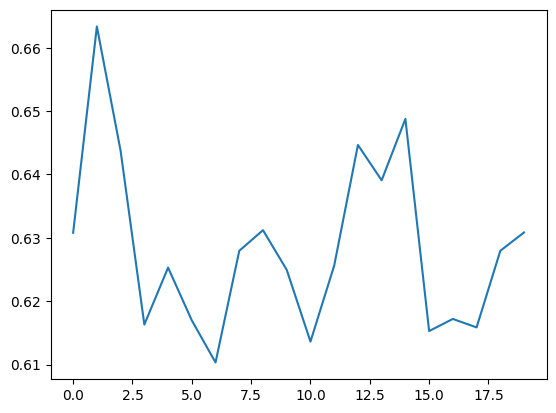

In [16]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

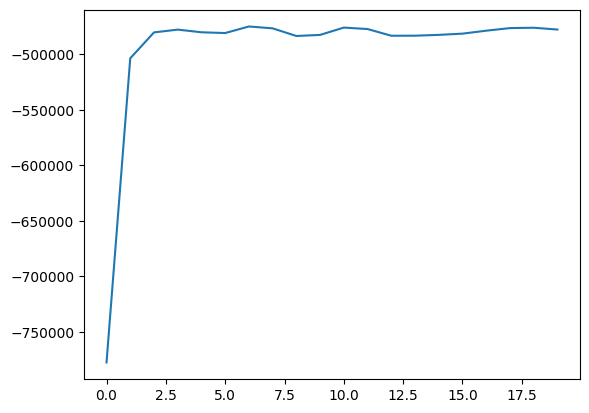

In [17]:
plt.plot(lhood)
plt.show()

In [18]:
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(y,cluster))

0.5362182315717479
